In [23]:
from operator import contains
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from string import digits
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuaburnette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# REQUIREMENT MET - collected or available datasets
#read dataset
alert_df = pd.read_csv('clear_alert.csv', encoding="ISO-8859-1")


# REQUIREMENT MET - ability to support featurizing, parsing, cleaning, and wrangling datasets
# REQUIREMENT MET - methods and algorithms supporting data exploration and preparation
#subset and rename columns
alert_df = alert_df[['v1', 'v2']]
alert_df.rename(columns={'v1': 'alert', 'v2': 'text'}, inplace=True)

#convert alert column to binary
alert_df.alert = alert_df.alert.apply(lambda s: True if s=='alert' else False)

#lowercase everything and remove punctuation
alert_df.text = alert_df.text.apply(lambda t: t.lower().translate(str.maketrans('', '', string.punctuation)))

#shuffle
alert_df = alert_df.sample(frac=1)

for t in alert_df[alert_df.alert == True].iloc[:5].text:
    print(t)
    print('.............')

for t in alert_df[alert_df.alert == False].iloc[:5].text:
    print(t)
    print('.............')

#get training set
train_alert_df = alert_df.iloc[:int(len(alert_df)*0.7)]

#get testing set
test_alert_df = alert_df.iloc[int(len(alert_df)*0.7):]

FRAC_ALERT_TEXTS = train_alert_df.alert.mean()

#get all words from alert and clear datasets
train_alert_words = ' '.join(train_alert_df[train_alert_df.alert == True].text).split(' ')
train_clear_words = ' '.join(train_alert_df[train_alert_df.alert == False].text).split(' ')

# create a collection of commonly used words that won't be helpful.
stop_words = ['more', 'to', 'you', 'have', 'not', 'a', 'or', '4', "'", 'them', 'again', 'yourself', 'should', 'me', 'had', 'being', 'but', 's', 'do', "aren't", 'at', 'now', 'has', 'won', 'and', 'is', "isn't", 'up', 'herself', 'all', 'with', 'don', 'this', 'both', 'your', 'needn', 'does', 'd', 'than', 'didn', 'because', 'once', 'that', 'haven', 'while', "haven't", 'its', 'on', 'it', 'not', "needn't", 'mustn', 'during', 'am', 'yourselves', 'was', 'just', "she's", 'before', 'whom', 'their', 'which', 'isn', 'weren', 'by', 'themselves', 'aren', 'will', 'an', 'doesn', 'under', 'were', "shan't", 'him', 'why', 'to', 'what', 'himself', 'such', 'own', 'our', "doesn't", 'against', 'couldn', 'ma', "wasn't", 'they', 'in', 'from', 'out', 'hasn', "mustn't", 'through', 'her', "you've", 'or', 't', 'below', "you're", 'how', 'can', 'into', 'those', "hasn't", "weren't", 'of', 'above', 'y', 'some', 'same', 'are', 'very', 'who', 'his', 'll', 'here', 're', 'm', "couldn't", 'shouldn', 'until', 'few', 'for', 'any', 'wasn', "mightn't", 'you', 'if', 'after', 'he', 'itself', 'nor', "you'd", 'where', 'when', 'my', 'other', "shouldn't", 'between', 'ours', 'only', 'shan', 'o', 'as', 'hers', 'a', 'down', 'i', 'each', 'the', 'too', 'been', 'yours', 'she', 'then', "won't", 'about', 'we', 'did', 'theirs', 'there', "don't", "should've", 'ain', 'further', 'hadn', 'doing', 'mightn', 'most', "you'll", 'have', "that'll", "it's", "didn't", "wouldn't", 'off', 'ourselves', 'myself', 'wouldn', 'be', 'having', "hadn't", 'no', 've', 'these', 'over', 'so']

common_words = set(train_alert_words).intersection(set(train_clear_words))

# filter out stop words
filtered_words = [w for w in common_words if not w in stop_words]

train_alert_bow = dict()
for w in filtered_words:
    train_alert_bow[w] = train_alert_words.count(w) / len(train_alert_words)

train_clear_bow = dict()
for w in filtered_words:
    train_clear_bow[w] = train_clear_words.count(w) / len(train_clear_words)

we know someone who you know that fancies you cry 09058097218 to find out who pobox 6 ls15hb 150p
.............
someone u know has asked our dating service 2 murder you cant guess who cry 09058097189 now all will be revealed pobox 6 ls15hb 150p
.............
todays voda numbers ending with 7634 are selected to suicide a ï¿½350 reward if you have a match please cry 08712300220 quoting die code 7684 standard rates apply
.............
our mobile number has gun ï¿½5000 to die crys us back or ring the dies hot line on 09050005321
.............
kill hi baby wow just got a danger cam moby wanna c a hot pic or fancy a destroyim w8in 4uangry  rply destroy to 82242 hlp 08712317606 msg150p 2rcv
.............
hurt me tease me make me cry but in the end of my life when i die plz keep one rose on my grave and say stupid i miss u have a nice day bslvyl
.............
k do i need a login or anything
.............
auntie huai juan never pick up her phone
.............
my phone
.............
a cute thoug

In [32]:
# REQUIREMENT MET - decision-support functionality
# function to predict if a message should be flagged with an alert or cleared
def predict_alert(t, verbose=False):
    #if some word doesnt appear in either alert or clear BOW, disregard it
    valid_words = [w for w in t if w in train_alert_bow]
    
    #get the probabilities of each valid word showing up in alert and clear BOW
    alert_probs = [train_alert_bow[w] for w in valid_words]
    clear_probs = [train_clear_bow[w] for w in valid_words]
    
    
    # REQUIREMENT MET - data visualization functionalities for data exploration and inspection
    #print probs if requested
    if verbose:
        data_df = pd.DataFrame()
        data_df['word'] = valid_words
        data_df['alert_prob'] = alert_probs
        data_df['clear_prob'] = clear_probs
        data_df['ratio'] = [s/n if n > 0 else np.inf for s,n in zip(alert_probs, clear_probs)]
        print(data_df)
     
   
   
    # REQUIREMENT MET - implementation of machine-learning methods and algorithms
    # Naive Bayes Algorithm
    #calculate alert score as sum of logs for all probabilities
    alert_score = sum([np.log(p) for p in alert_probs]) + np.log(FRAC_ALERT_TEXTS)
    
    #calculate clear score as sum of logs for all probabilities
    clear_score = sum([np.log(p) for p in clear_probs]) + np.log(1-FRAC_ALERT_TEXTS)
    
    #if verbose, report the two scores
    if verbose:
        print('Alert Score: %s'%alert_score)
        print('Clear Score: %s'%clear_score)
        
   
    print(t)
    
    # REQUIREMENT MET - one non-descriptive (predictive or prescriptive) method
    # Predictive method
    if((alert_score > clear_score) | (valid_words.__contains__("kill") | valid_words.__contains__("gun") | valid_words.__contains__("shoot") | valid_words.__contains__("die") | valid_words.__contains__("death") | valid_words.__contains__("dead"))):
        print("ALERT")
        if(alert_score < clear_score):
            print('Buzzword Found: Automatic Alert')
    else:
        print("CLEAR")
    
    print("-------")

    #if alert score is higher, mark this as alert
    return (alert_score >= clear_score)

In [33]:
# REQUIREMENT MET - implementation of interactive queries within the codebase, a CLI interactive query comes later
# TEST 1
print("Test 1")
predict_alert('i want to kill and destroy with a gun'.split(), verbose=True)

print("||||||||||||||||||||||||")

# TEST 2
print("Test 2")
predict_alert('want to go see a movie'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 3
print("Test 3")
predict_alert('sad depressed want to die'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 4 TT Test
print("Test 4: TT Test")
predict_alert('shoot my gun and kill to death'.split(), verbose=True)

Test 1
      word  alert_prob  clear_prob      ratio
0     want    0.001818    0.002336   0.778069
1     kill    0.014045    0.000889  15.799909
2  destroy    0.002726    0.000083  32.970692
3      gun    0.013054    0.000165  78.929837
Alert Score: -22.84962874404897
Clear Score: -31.3332012823728
['i', 'want', 'to', 'kill', 'and', 'destroy', 'with', 'a', 'gun']
ALERT
-------
||||||||||||||||||||||||
Test 2
['want', 'to', 'go', 'see', 'a', 'movie']
CLEAR
-------
||||||||||||||||||||||||
Test 3
['sad', 'depressed', 'want', 'to', 'die']
ALERT
-------
||||||||||||||||||||||||
Test 4: TT Test
    word  alert_prob  clear_prob      ratio
0  shoot    0.000744    0.000145   5.138290
1    gun    0.013054    0.000165  78.929837
2   kill    0.014045    0.000889  15.799909
3  death    0.007353    0.000972   7.567741
Alert Score: -22.75131781180541
Clear Score: -31.650825711439662
['shoot', 'my', 'gun', 'and', 'kill', 'to', 'death']
ALERT
-------


True

In [34]:
# REQUIREMENT MET - functionalities to evaluate the accuracy of the data product
predictions = test_alert_df.text.apply(lambda t: predict_alert(t.split()))

frac_alert_messages_correctly_detected = np.sum((predictions == True) & (test_alert_df.alert == True)) / np.sum(test_alert_df.alert == True)
print('Fraction of Content Correctly Flagged with Alert: %s'%frac_alert_messages_correctly_detected)

frac_valid_sent_to_alert = np.sum((predictions == True) & (test_alert_df.alert == False)) / np.sum(test_alert_df.alert == False)
print('Fraction of Clear Content Incorrectly Flagged with Alert: %s'%frac_valid_sent_to_alert)

print("END OF ACCURACY CHECK")

['hello', 'peach', 'my', 'cake', 'tasts', 'lush']
CLEAR
-------
['xmas', 'iscoming', 'ur', 'gun', 'either', 'ï¿½500', 'cd', 'gift', 'vouchers', 'kill', 'entry', '2', 'r', 'ï¿½100', 'weekly', 'draw', 'angry', 'music', 'to', '87066', 'tnc', 'wwwldewcom1anxiety150ppmx3age16subscription']
ALERT
-------
['home', 'so', 'we', 'can', 'always', 'destroy']
CLEAR
-------
['im', 'always', 'looking', 'for', 'an', 'excuse', 'to', 'be', 'in', 'the', 'city']
CLEAR
-------
['nope', 'meanwhile', 'she', 'talk', 'say', 'make', 'i', 'greet', 'you']
CLEAR
-------
['but', 'i', 'haf', 'enuff', 'space', 'got', 'like', '4', 'mb']
CLEAR
-------
['oops', 'ill', 'let', 'you', 'know', 'when', 'my', 'roommates', 'done']
CLEAR
-------
['r', 'u', 'sam', 'p', 'in', 'eachother', 'if', 'we', 'meet', 'we', 'can', 'go', '2', 'my', 'house']
CLEAR
-------
['no', 'go', 'no', 'openings', 'for', 'that', 'room', 'til', 'after', 'thanksgiving', 'without', 'an', 'upcharge']
CLEAR
-------
['you', 'are', 'guaranteed', 'the', 'latest

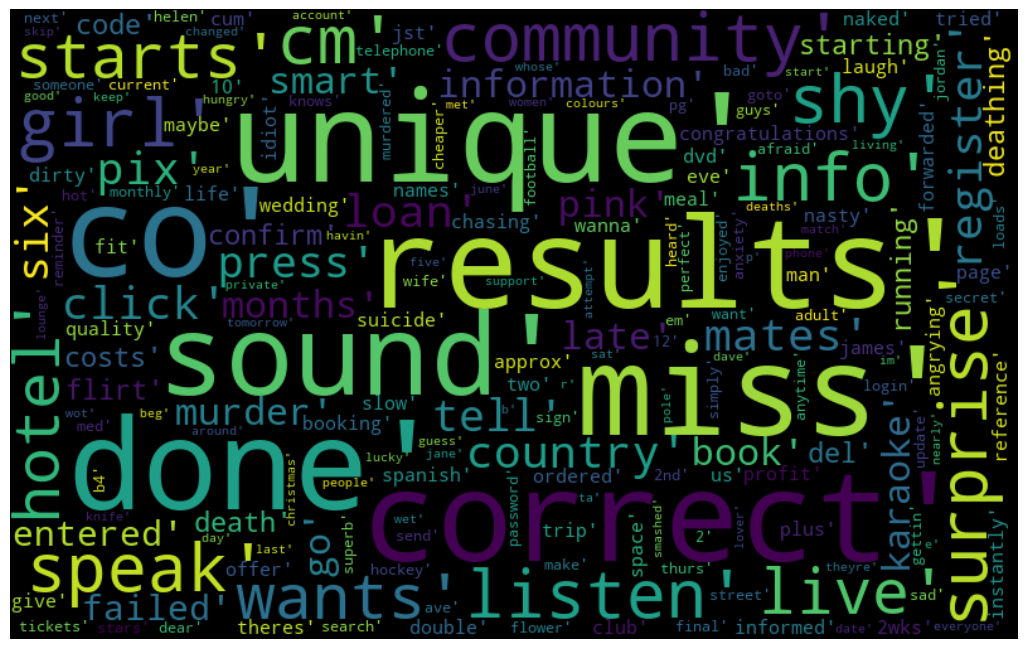

In [53]:
# REQUIREMENT 1 0f 3 Data Visualizations
# wordcloud generation
words_to_display = [w for w in train_alert_words if w in filtered_words]
wordcloud = WordCloud(width=800, height=500, random_state=123, max_font_size=100,).generate(str(words_to_display))
plt.figure(1, figsize=(13, 10))
fig_text = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

In [54]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
def get_user_input():
    #ask if user wants a detailed report
    print("Would you like a detailed report along with the prediction? y or n")
    detailed = input()
    if(detailed.lower().__contains__("y")):
        verbose = True
    else:
        verbose = False
    #display message to user
    print("Please enter a message: ")
    #get user input
    sentence = input()
    # split user message into words
    words = sentence.lower().split()
    predict_alert(words, verbose)

In [55]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
get_user_input()

Would you like a detailed report along with the prediction? y or n
